# Computational Geometry (for Gesture Recognition)

Our overall goal: recognize gestures drawn with the Wiimote or a light pen or the mouse on a canvas

## Example: \$1 Gesture Recognizer (Wobbrock et al. )

https://depts.washington.edu/aimgroup/proj/dollar/

 * Step 1: resample path into 64 evenly spaced points
  * find total length of original path, divide by 64 = step size
  * follow original path, create new point after step size
 * Step 2: correct angle
  * find centroid of points
  * shift all points so that centroid is at (0,0)
  * find angle a between centroid and first point
  * rotate all points by -a
 * Step 3: correct size
  * find size of bounding box
  * scale all points so that BB size is (100,100)
 * Step 4: compare to templates
  * for each template:
    * for each point:
      * calculate distance between template point and current point
      * add to total distance
  * return template with minimum total distance

![Image: one_dollar](img/one_dollar.svg)

Populating the interactive namespace from numpy and matplotlib


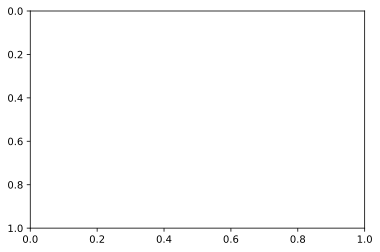

In [4]:
%pylab inline
%config InlineBackend.figure_format='svg'
plt.gca().invert_yaxis() # use screen coordinate system
# integrate qt5 event loop
%gui qt5
# only execute the next cell once this cell has been completely executed (i.e., the `[*]` has turned into `[2]`)

In [5]:
from PyQt5 import QtWidgets, QtCore, QtGui
# from math import sin, cos, pi # (already imported by pylab)
# only execute the next cell once this cell has been completely executed (i.e., the `[*]` has turned into `[2]`)

In [6]:
app = QtWidgets.QApplication(sys.argv)

In [7]:
class QDrawWidget(QtWidgets.QWidget):
    
    def __init__(self, width=800, height=800):
        super().__init__()
        self.resize(width, height)
        self.setFocusPolicy(QtCore.Qt.StrongFocus)
        self.drawing = False
        self.grid = True
        self.points = []
        self.setMouseTracking(True) # only get events when button is pressed
        self.initUI()

    def initUI(self):      
        self.setWindowTitle('Drawable')
        self.show()
        
    def mousePressEvent(self, ev):
        if ev.button() == QtCore.Qt.LeftButton:
            print("here")
            self.drawing = True
            self.points = []
            
        elif ev.button() == QtCore.Qt.RightButton:
            try:
                self.points = custom_filter(self.points) # needs to be implemented outside!
            except NameError:
                pass
            
        self.update()
            
    def mouseReleaseEvent(self, ev):
        if ev.button() == QtCore.Qt.LeftButton:
            self.drawing = False
            self.update() 

    def mouseMoveEvent(self, ev):
        if self.drawing:
            self.points.append((ev.x(), ev.y()))
            self.update() 
    
    def poly(self, pts):
        return QtGui.QPolygonF(map(lambda p: QtCore.QPointF(*p), pts))

    def paintEvent(self, ev):
        qp = QtGui.QPainter()
        qp.begin(self)
        qp.setBrush(QtGui.QColor(0, 0, 0))
        qp.drawRect(ev.rect())
        qp.setBrush(QtGui.QColor(20, 255, 190))
        qp.setPen(QtGui.QColor(0, 155, 0))
        qp.drawPolyline(self.poly(self.points))
        
        for point in self.points:
            qp.drawEllipse(point[0] - 1, point[1] - 1, 2, 2)
        if self.grid:
            qp.setPen(QtGui.QColor(255, 100, 100, 20))  # semi-transparent
            
            for x in range(0, self.width(), 20):
                qp.drawLine(x, 0, x, self.height())
                
            for y in range(0, self.height(), 20):
                qp.drawLine(0, y, self.width(), y)
                
        qp.end()

In [8]:
dw = QDrawWidget() # a new window should open - draw into it!

In [9]:
def distance(p1,p2):
    # basic vector norm
    
    dx = p1[0] - p2[0]
    dy = p1[1] - p2[1]
    
    return sqrt(dx * dx + dy * dy)

def total_length(point_list):
    # calculate the sum of the distances of all points along the drawn stroke
    
    p1 = point_list[0]
    length = 0.0
    
    for i in range(1, len(point_list)):
        length += distance(p1, point_list[i])
        p1 = point_list[i]
            
    return length

In [10]:
pl = [(454, 382), (456, 384), (459, 385), (463, 388), (473, 394), (480, 397), (489, 401), (493, 401), (504, 404), (530, 406), (553, 408), (561, 408), (588, 408), (603, 408), (621, 403), (654, 390), (707, 361), (740, 342), (803, 299), (822, 283), (872, 243), (901, 219), (927, 198), (948, 178), (975, 151), (988, 137), (994, 132), (1004, 122), (1011, 114), (1014, 112), (1019, 107), (1022, 104), (1024, 101), (1026, 100), (1027, 98), (1028, 97), (1030, 95), (1031, 94), (1032, 93)]

def resample(point_list, step_count=64):
    # resample the given stroke's list of points
    # represent the stroke with the amount of step_count points
    
    # save here the resampled points
    newpoints = []
    
    # the sum of the distances of all points along the originally drawn stroke
    length = total_length(point_list)
    
    print(length)
    
    # the distance the resampled points have to each other
    stepsize = length / (step_count - 1)
    
    print(stepsize)
    
    # current position along the strong in regard of step_size (see below)
    curpos = 0
    
    # add the first point of the original stroke to the point list
    newpoints.append(point_list[0])
    
    # iterate the stroke's point list
    i = 1
    while i < len(point_list):
        p1 = point_list[i - 1]
        
        # calculate the distance of the current pair of points
        d = distance(p1,point_list[i])        
        
        if curpos + d >= stepsize:
            # once we reach or step over our desired distance, we push our resampled point
            # to the correct position based on our stepsize
            nx = p1[0] + ((stepsize - curpos) / d) * (point_list[i][0] - p1[0])
            ny = p1[1] + ((stepsize - curpos) / d) * (point_list[i][1] - p1[1])
                        
            # store the new data
            newpoints.append([nx,ny])
            point_list.insert(i,[nx,ny])
            
            # reset curpos
            curpos = 0
        else:
            curpos += d
            
        i += 1
                        
    return newpoints

print(len(resample(pl)))

692.476966951313
10.991697888116079
64


In [11]:
def rotate(points, center, angle_degree):
    new_points = []
    
    # represent our angle in radians
    angle_rad = angle_degree * (pi / 180)
    
    # define a 3x3 rotation matrix for clockwise rotation 
    rot_matrix = matrix([[cos(angle_rad), -sin(angle_rad), 0],
                         [sin(angle_rad),  cos(angle_rad), 0], 
                         [      0,               0,        1]])
    
    t1 = matrix([[1, 0, -center[0]], 
                 [0, 1, -center[1]],
                 [0, 0,     1     ]])
    
    t2 = matrix([[1, 0,  center[0]], 
                 [0, 1,  center[1]],
                 [0, 0,     1     ]])
    
    # create our actual transformation matrix which rotates a point of points around the center of points
    transform = t2  @ rot_matrix @ t1 # beware of the order of multiplications, not commutative!
    
    for point in points:
        
        # homogenous point of the point to be rotated
        hom_point = matrix([[point[0]], [point[1]], [1]])  
        
        # rotated point
        rotated_point = transform @ hom_point
        
        # storing
        new_points.append(( (rotated_point[0] / rotated_point[2]),float(rotated_point[1] / rotated_point[2])))
        
    return new_points

In [12]:
def centroid(points):
    xs, ys = zip(*points)
    
    return (sum(xs) / len(xs), sum(ys) / len(ys))

In [13]:
def angle_between(point, centroid):
    dx = centroid[0] - point[0]
    dy = centroid[1] - point[1]
    
    # return the angle in degrees
    return math.atan2(dy, dx) * 180 / math.pi 

assert(angle_between((-10, -10), (0,0)) == 45.0) 
# some 'unit testing' whether the function does what it is supposed to do

In [14]:
def scale(points):
    
    # the desired interval size
    size = 100
    
    xs, ys = zip(*points)
    
    # minimum and maximum occurrences of x and y values of the points
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    
    # calculate the range of the coordinates of the points
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    points_new = []
    
    # map the points to the desired interval
    for p in points:
        p_new = ((p[0] - x_min) * size / x_range,
                 (p[1] - y_min) * size / y_range)
        points_new.append(p_new)
        
    return points_new
    

In [15]:
def normalize(points):
    # use all the processing functions from above to transform our set of points into the desired shape
    points_new = resample(points)
    angle = -angle_between(points_new[0], centroid(points_new))
    points_new = rotate(points_new, centroid(points_new), angle)
    points_new = scale(points_new)
    
    return points_new

In [16]:
def custom_filter(points):
    return(normalize(points))

# set the draw widgets custom filter variable to the function of the same way which applies our transformation stack
dw.custom_filter = custom_filter

In [17]:
def transpose_points(points):
    return list(map(list, zip(*points)))

plot(transpose_points(dw.points)[0], transpose_points(dw.points)[1])

IndexError: list index out of range

In [ ]:
# screen coordinates vs draw widget coordinates ( y inverted! )
s1 = normalize([(-1,0), (0,-1), (1,0), (0,1)])

# shape:
# 
#   /\
#    /
#

#print(s1)

In [ ]:
def calculate_similarity(sample, template):
    dist_all = 0
    for p1, p2 in zip(sample,template):
        dist = abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])
        dist_all += dist
    return dist_all

In [15]:
sim = calculate_similarity(s1, normalize(dw.points))
print("print:", sim)

NameError: name 'calculate_similarity' is not defined